* https://github.com/hill-a/stable-baselines
* https://stable-baselines.readthedocs.io/en/master/

In [9]:
#!pip3 install kaggle --upgrade > /dev/null 2>&1
#!pip install 'kaggle-environments==0.1.6' > /dev/null 2>&1
#!pip install 'tensorflow-gpu == 1.14.0' > /dev/null 2>&1
#!pip install setuptools==65.5.0 pip==21
#!pip install stable-baselines3 -U

In [ ]:
!pip install -r requirements.txt

# Let's define enviroment

In [13]:
from kaggle_environments import make
import gym
import numpy as np

class ConnectX(gym.Env):
    """Custom Environment that follows gym interface"""

    def __init__(self, opponent_type):
        self.env = make("connectx", debug=True)
        self.trainer = self.env.train([None, opponent_type])
        self.obs = None
        self.action_space = gym.spaces.Discrete(self.env.configuration.columns)
        self.observation_space = gym.spaces.Box(0, 2, shape=(self.env.configuration.rows, self.env.configuration.columns), dtype=np.float32)

    def get_kaggle_env(self):
        return self.env

    def step(self, action):
        # Wrap kaggle environment.step()
        if self.obs[0][action] != 0:
            r = -1 # punish illegal move
            d = False
            o = self.obs
        else:
            o, r, d, _ = self.trainer.step(int(action))
            o = np.reshape(np.array(o['board']), (self.env.configuration.rows, self.env.configuration.columns))
            self.obs = o

        return o, float(r), bool(d), {}

    def reset(self):
        o = self.trainer.reset()
        self.obs = np.reshape(np.array(o['board']), (self.env.configuration.rows, self.env.configuration.columns))
        return self.obs

    def render(self, **kwargs):
        return self.env.render(**kwargs)


In [14]:
!pwd

/mnt/c/svn/rl/connectx


In [15]:
import gym


import torch
from torch.utils.tensorboard import SummaryWriter

# from stable_baselines3.common.policies import MlpPolicy
from stable_baselines3 import PPO, A2C, DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy

# Create log dir
import os
log_dir = "/kaggle/working/"
log_dir = '/mnt/c/svn/rl/connectx/runs/' # for local
# os.makedirs(log_dir, exist_ok=True)

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

def plot(frame_idx, rewards, mean_rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. mean reward: %s' % (frame_idx, mean_rewards[-1]))
    plt.plot(rewards, color='b')
    plt.plot(mean_rewards, color='y')
#     plt.subplot(132)
#     plt.title('loss')
#     plt.plot(losses)
    plt.show()

rewards = []
mean_rewards = []

def callback(_locals, _globals):
    """
    Callback called at each step (for DQN an others) or after n steps (see ACER or PPO2)
    :param _locals: (dict)
    :param _globals: (dict)
    """
    global best_mean_reward, mean_rewards, rewards, name_policy, writer, name_policy
    # Evaluate policy training performance
    x, y = ts2xy(load_results(log_dir), 'timesteps')
    if len(x) > 0:
        rewards.append(y[-1])
        mean_reward = np.mean(y[-100:])
        mean_rewards.append(mean_reward)
        frame_idx = x[-1]
        writer.add_scalar("Reward", y[-1], frame_idx)
        writer.add_scalar("Mean reward", mean_reward, frame_idx)

        # plot(x[-1], rewards, mean_rewards)
        # print(x[-1], 'timesteps')
        # print("Best / last mean reward per episode: {:.2f} / {:.2f}".format(best_mean_reward, mean_reward))

        # New best model, you could save the agent here
        if mean_reward > best_mean_reward:
            best_mean_reward = mean_reward
            # Example for saving best model
            print(f"*** Saving new best model - {name_policy} ***, reward = {best_mean_reward}" )
            _locals['self'].save(log_dir + name_policy + '_best_model.pkl')
    return True

# gym_env = ConnectX('random')
gym_env = ConnectX('negamax')
env = Monitor(gym_env, log_dir, allow_early_resets=True)
env = DummyVecEnv([lambda: env])


# Train some basic algs

In [8]:
writer = None
best_mean_reward = -1_000_000
name_policy = None

def train_sb3_model(alg, type_policy, total_timesteps):
    global writer, best_mean_reward, name_policy
    best_mean_reward = -1_000_000
    name_policy = f'{alg}_{type_policy}'
    writer = SummaryWriter(log_dir=log_dir, comment=alg)
    if alg == 'dqn':
        model = DQN(type_policy, env)
    elif alg == 'a2c':
        model = A2C(type_policy, env)
    elif alg == 'ppo':
        model = PPO(type_policy, env)
    model.learn(total_timesteps=total_timesteps, callback=callback, log_interval=4)
    model.save(name_policy)
    writer.close()

train_sb3_model('dqn', 'MlpPolicy', 150_000)
train_sb3_model('a2c', 'MlpPolicy', 50_000)
train_sb3_model('ppo', 'MlpPolicy', 50_000)



*** Saving new best model ***, reward = 1.5
*** Saving new best model ***, reward = 1.8888888888888888
*** Saving new best model ***, reward = 1.9545454545454546
*** Saving new best model ***, reward = 2.0833333333333335
*** Saving new best model ***, reward = 2.269230769230769
*** Saving new best model ***, reward = 2.5
*** Saving new best model ***, reward = 2.65625
*** Saving new best model ***, reward = 2.7777777777777777
*** Saving new best model ***, reward = 2.8157894736842106
*** Saving new best model ***, reward = 2.825
*** Saving new best model ***, reward = 3.09
*** Saving new best model ***, reward = 3.19
*** Saving new best model ***, reward = 3.8
*** Saving new best model ***, reward = 3.81
*** Saving new best model ***, reward = 3.815
*** Saving new best model ***, reward = 3.82
*** Saving new best model ***, reward = 3.825
*** Saving new best model ***, reward = 3.865
*** Saving new best model ***, reward = 3.905
*** Saving new best model ***, reward = 5.465
*** Saving 

*** Saving new best model ***, reward = 9.075
*** Saving new best model ***, reward = 9.08
*** Saving new best model ***, reward = 9.085
*** Saving new best model ***, reward = 9.09
*** Saving new best model ***, reward = 9.095
*** Saving new best model ***, reward = 9.285
*** Saving new best model ***, reward = 9.295
*** Saving new best model ***, reward = 9.31
*** Saving new best model ***, reward = 9.325
*** Saving new best model ***, reward = 9.335
*** Saving new best model ***, reward = 9.34
*** Saving new best model ***, reward = 9.35
*** Saving new best model ***, reward = 9.355
*** Saving new best model ***, reward = 9.365
*** Saving new best model ***, reward = 9.37
*** Saving new best model ***, reward = 9.375
*** Saving new best model ***, reward = 9.395
*** Saving new best model ***, reward = 9.405
*** Saving new best model ***, reward = 9.41
*** Saving new best model ***, reward = 9.415
*** Saving new best model ***, reward = 9.42
*** Saving new best model ***, reward = 9.

In [9]:
# pip install sb3-contrib  -- NOT STABLE with COnnectX ENV
# from sb3_contrib import QRDQN

# policy_kwargs = dict(n_quantiles=50)
# model = QRDQN("MlpPolicy", env, policy_kwargs=policy_kwargs, verbose=1)
# model.learn(total_timesteps=10000, log_interval=4)
# model.save("QRDQN")

In [16]:
def ppo_agent(observation, configuration):
    if np.sum(observation['board']) == 0: 
        return np.random.randint(7)
    obs = np.array(observation['board']).reshape(6,7)
    action, _states = ppo_model.predict(obs, deterministic=True)
    return int(action)

def a2c_agent(observation, configuration):
    if np.sum(observation['board']) == 0: 
        return np.random.randint(7)
    obs = np.array(observation['board']).reshape(6,7)
    action, _states = a2c_model.predict(obs, deterministic=True)
    return int(action)

def dqn_agent(observation, configuration):
    if np.sum(observation['board']) == 0: 
        return np.random.randint(7)
    obs = np.array(observation['board']).reshape(6,7)
    action, _states = dqn_model.predict(obs, deterministic=True)
    return int(action)

def get_empty_row(action, obs, allow_rows):
    if obs[0][0][action] != 0:
        if action in allow_cols:
            allow_rows.pop(allow_rows.index(action))
        action = np.random.choice(allow_rows, 1)[0]
    return [action]

def play_test_policy(model):
    done = False
    obs = env.reset()
    step_cnt = 0
    max_moves = gym_env.get_kaggle_env().configuration.columns * gym_env.get_kaggle_env().configuration.rows
    allow_cols = [i for i in range(7)]
    while (not done) and step_cnt <= max_moves:
        step_cnt += 1
        print(obs)
        action, _states = model.predict(obs, deterministic=True)
        print(action[0])
        # find empty row and sample random if action col is full
        action = get_empty_row(action[0], obs, allow_cols)
        print('action:', action)
        obs, reward, done, info = env.step(action)
        gym_env.render()
        print(reward, done)
        print()


# Evaluate the algs

In [17]:
# testing policy
ppo_model = PPO.load(log_dir +'ppo_MlpPolicy_best_model.pkl', env)
play_test_policy(ppo_model)

[[[0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]]]
0
action: [0]
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 2 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 1 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+

[0.5] [False]

[[[0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [2. 0. 0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0. 0. 0.]]]
2
action: [2]
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 2 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+-

In [18]:
# testing policy
a2c_model = A2C.load(log_dir + 'a2c_MlpPolicy_best_model.pkl', env)
play_test_policy(a2c_model)

[[[0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]]]
4
action: [4]
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 2 | 0 | 0 | 0 | 1 | 0 | 0 |
+---+---+---+---+---+---+---+

[0.5] [False]

[[[0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [2. 0. 0. 0. 1. 0. 0.]]]
0
action: [0]
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 2 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+-

+---+---+---+---+---+---+---+
| 2 | 2 | 0 | 1 | 2 | 2 | 0 |
+---+---+---+---+---+---+---+
| 2 | 2 | 0 | 2 | 2 | 1 | 0 |
+---+---+---+---+---+---+---+
| 1 | 1 | 0 | 1 | 2 | 2 | 0 |
+---+---+---+---+---+---+---+
| 2 | 1 | 0 | 1 | 1 | 1 | 0 |
+---+---+---+---+---+---+---+
| 1 | 2 | 0 | 1 | 1 | 2 | 0 |
+---+---+---+---+---+---+---+
| 2 | 1 | 1 | 2 | 1 | 1 | 2 |
+---+---+---+---+---+---+---+

[0.5] [False]

[[[2. 2. 0. 1. 2. 2. 0.]
  [2. 2. 0. 2. 2. 1. 0.]
  [1. 1. 0. 1. 2. 2. 0.]
  [2. 1. 0. 1. 1. 1. 0.]
  [1. 2. 0. 1. 1. 2. 0.]
  [2. 1. 1. 2. 1. 1. 2.]]]
2
action: [2]
+---+---+---+---+---+---+---+
| 2 | 2 | 0 | 1 | 2 | 2 | 0 |
+---+---+---+---+---+---+---+
| 2 | 2 | 0 | 2 | 2 | 1 | 0 |
+---+---+---+---+---+---+---+
| 1 | 1 | 0 | 1 | 2 | 2 | 0 |
+---+---+---+---+---+---+---+
| 2 | 1 | 2 | 1 | 1 | 1 | 0 |
+---+---+---+---+---+---+---+
| 1 | 2 | 1 | 1 | 1 | 2 | 0 |
+---+---+---+---+---+---+---+
| 2 | 1 | 1 | 2 | 1 | 1 | 2 |
+---+---+---+---+---+---+---+

[0.5] [False]

[[[2. 2. 0. 1. 2. 2. 0

In [19]:
# testing policy
dqn_model = DQN.load(log_dir + 'dqn_MlpPolicy_best_model.pkl', env)
play_test_policy(dqn_model)

[[[0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]]]
3
action: [3]
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 2 | 0 | 0 | 1 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+

[0.5] [False]

[[[0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [2. 0. 0. 1. 0. 0. 0.]]]
5
action: [5]
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+-

+---+---+---+---+---+---+---+
| 2 | 0 | 2 | 2 | 2 | 0 | 0 |
+---+---+---+---+---+---+---+
| 2 | 2 | 1 | 1 | 2 | 0 | 0 |
+---+---+---+---+---+---+---+
| 2 | 1 | 2 | 2 | 1 | 0 | 2 |
+---+---+---+---+---+---+---+
| 1 | 2 | 1 | 1 | 1 | 2 | 1 |
+---+---+---+---+---+---+---+
| 2 | 1 | 1 | 2 | 1 | 1 | 1 |
+---+---+---+---+---+---+---+
| 2 | 2 | 1 | 1 | 2 | 1 | 1 |
+---+---+---+---+---+---+---+

[0.5] [False]

[[[2. 0. 2. 2. 2. 0. 0.]
  [2. 2. 1. 1. 2. 0. 0.]
  [2. 1. 2. 2. 1. 0. 2.]
  [1. 2. 1. 1. 1. 2. 1.]
  [2. 1. 1. 2. 1. 1. 1.]
  [2. 2. 1. 1. 2. 1. 1.]]]
5
action: [5]
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+

[0.] [ True]



In [20]:
kaggle_env = gym_env.get_kaggle_env()
kaggle_env.reset()
kaggle_env.run([a2c_agent, "negamax"])
kaggle_env.render(mode="ipython", width=500, height=450)

In [21]:
kaggle_env = gym_env.get_kaggle_env()
kaggle_env.reset()
kaggle_env.run([dqn_agent, "negamax"])
kaggle_env.render(mode="ipython", width=500, height=450)

In [16]:
from kaggle_environments import evaluate

def mean_reward(rewards):
    r0 =[r[0] if r[0] is not None else 0 for r in rewards]
    r1 =[r[1] if r[1] is not None else 0 for r in rewards]
    return sum(r for r in r0) / sum(r0 + r1 for r0, r1 in zip(r0, r1))

In [17]:
allowed_algs = [ppo_agent, a2c_agent, dqn_agent, "random_agent", "negamax_agent"]

isinstance(ppo_agent, str)

False

In [18]:
import re

res = []

from itertools import product
allowed_algs = [ppo_agent, a2c_agent, dqn_agent, "random", "negamax"]
for (a1, a2) in product(allowed_algs, allowed_algs):
    if isinstance(a1, str):
        alg1_name = a1
    else:
        alg1_name = re.search("([a-z0-9]+_agent)", str(a1)).group(1)
    if isinstance(a2, str):
        alg2_name = a2
    else:
        alg2_name = re.search("([a-z0-9]+_agent)", str(a2)).group(1)
    s = f"{alg1_name} vs {alg2_name}:"
    mean_r = mean_reward(evaluate("connectx", [a1, a2], num_episodes=50))
    res.append({'Battle': s, 'Mean Reward': mean_r})
    print(s, mean_r)

ppo_agent vs ppo_agent: 0.14
ppo_agent vs a2c_agent: 0.13333333333333333
ppo_agent vs dqn_agent: 0.44
ppo_agent vs random: 0.7157894736842105
ppo_agent vs negamax: 0.0
a2c_agent vs ppo_agent: 0.7837837837837838
a2c_agent vs a2c_agent: 0.5714285714285714
a2c_agent vs dqn_agent: 0.76
a2c_agent vs random: 0.8
a2c_agent vs negamax: 0.6067415730337079
dqn_agent vs ppo_agent: 0.52
dqn_agent vs a2c_agent: 0.94
dqn_agent vs dqn_agent: 0.44
dqn_agent vs random: 0.8
dqn_agent vs negamax: 0.0
random vs ppo_agent: 0.42857142857142855
random vs a2c_agent: 0.3333333333333333
random vs dqn_agent: 0.28
random vs random: 0.46
random vs negamax: 0.02
negamax vs ppo_agent: 1.0
negamax vs a2c_agent: 0.0
negamax vs dqn_agent: 1.0
negamax vs random: 0.99
negamax vs negamax: 0.0


In [19]:
import pandas as pd
pd.DataFrame.from_records(res).sort_values('Mean Reward', ascending=False)

,Battle,Mean Reward
20,negamax vs ppo_agent:,1.000000
22,negamax vs dqn_agent:,1.000000
23,negamax vs random:,0.990000
11,dqn_agent vs a2c_agent:,0.940000
13,dqn_agent vs random:,0.800000
8,a2c_agent vs random:,0.800000
5,a2c_agent vs ppo_agent:,0.783784
7,a2c_agent vs dqn_agent:,0.760000
3,ppo_agent vs random:,0.715789
9,a2c_agent vs negamax:,0.606742


# Выводы

 - Судя по всему выгодно начинать игру первым,
 - Все алгоритмы учились на том что начинать игру первым, поэтому нужно пробовать делать так чтобы 50% игр начинались с шага оппонента,
 - negamax выигрывает у ppo_agent - надо учить агента с обратной стратегией, когда ppo_agent начинает играть вторым
 - dqn_agent даже без Dueling Network и Rainbow уже неплохо справляется если начинает первым
 - нужно доработать стратегию, чтобы при выборе действия в заполненный столбец - она не выбирала следующее дейстие случайным - кажется, что это место может сильно улучшить качество работы алгоритма
 


In [20]:
kaggle_env = gym_env.get_kaggle_env()
kaggle_env.reset()
kaggle_env.run([a2c_agent, ppo_agent])
kaggle_env.render(mode="ipython", width=500, height=450)

# Let's try to apply Dyna-Q (from seminar)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random
from functools import partial
from IPython.display import clear_output

%matplotlib inline

def show_progress(avg_returns):
    """
    Удобная функция, которая отображает прогресс обучения.
    """
    clear_output(True)
    plt.figure(figsize=[12, 4])
    plt.subplot(1, 1, 1)
    plt.plot(*zip(*avg_returns), label='Mean return')
    plt.legend(loc=4)
    plt.grid()
    plt.show()

def compare_logs(logs):
    """Функция сравнения кривых обучения"""
    plt.figure(figsize=[12, 6])
    for log, method_name in logs:
        plt.plot(*zip(*log), label=f'{method_name}')
        plt.legend()
    plt.grid()
    plt.show()

In [4]:
class Model:
    def __init__(self, n_states, n_actions, seed):
        self.mask_state = np.zeros([n_states], dtype=int)
        self.mask_state_action = np.zeros([n_states, n_actions], dtype=int)
        self.r = np.zeros_like(self.mask_state_action, dtype=float)
        self.next_s = np.zeros_like(self.mask_state_action, dtype=int)
        self._rng = np.random.default_rng(seed)

    def add(self, s: int, a: int, r: float, next_s: int) -> float:
        self.mask_state[s] = 1
        self.mask_state_action[s, a] = 1
        self.r[s, a] = r
        self.next_s[s, a] = next_s
        # Store reward and next state
        return r

    def sample(self) -> tuple[int, int, float, int]:
        """
        returns s, a, r, next_s
        """
        s = self._rng.choice(self.mask_state.nonzero()[0])
        a = self._rng.choice(self.mask_state_action[s].nonzero()[0])
        return s, a, self.r[s,a], self.next_s[s,a]


In [5]:
class DynaQAgent:
    def __init__(self, n_states, n_actions, lr, gamma, eps, f_model, seed):
        self.Q = np.zeros((n_states, n_actions))
        self.model = f_model(n_states, n_actions, seed=seed)
        self.lr = lr
        self.gamma = gamma
        self.eps = eps
        self.n_actions = n_actions
        self._rng = np.random.default_rng(seed)
        
    def act(self, s):
        s = s.reshape(-1)
        # выбираем действие, используя eps-greedy исследование среды
        # с вероятностью epsilon выбираем случайное действие, иначе
        # выполняем действие жадно, согласно текущей Q-таблице
        if self._rng.random() < self.eps:
            action = self._rng.choice(self.n_actions)
        else:
            action = np.argmax(self.Q[s])%self.n_actions  # используем Q-функцию
        return action

    def update(self, s, a, r, s_n, update_model: bool):
        s = s.reshape(-1)
        s_n = s_n.reshape(-1)
        # Обновите модель, если нужно, реализуйте шаг Q-обучения
        ####### Здесь ваш код ########
        if update_model:
            self.model.add(s,a,r,s_n)
        # alpha = lr
        self.Q[s,a] += self.lr * (r + self.gamma*np.max(self.Q[s_n])- self.Q[s, a])
        ##############################
        
    def dream(self, max_steps):
        for _ in range(max_steps):
            # Добавьте шаг обучения с использованием модели
            ####### Здесь ваш код ########
            s, a, r, next_s = self.model.sample()
            self.update(s, a, r, next_s, False)
            ##############################

In [6]:
def train(env, agent, n_episodes, on_model_updates, seed, show_progress_schedule=50):
    avg_returns, returns_batch = [], []
    rng = np.random.default_rng(seed)

    for i in range(1, n_episodes):
        state = env.reset() #seed=int(rng.integers(10000000)))
        reward, episode_return = 0, 0

        while True:
            action = agent.act(state)
#             print(action)

            # выполняем действие в среде
            next_state, reward, terminated, info = env.step(action)
#             print(state)
            agent.update(state.reshape(-1), action, reward, next_state.reshape(-1), update_model=True)
            state = next_state
            episode_return += reward
            done = terminated # or truncated
            if done:
                break
            agent.dream(on_model_updates)

        returns_batch.append(episode_return)

        if i % show_progress_schedule == 0:
            avg_returns.append((i, np.mean(returns_batch)))
            returns_batch = []
            
            show_progress(avg_returns)
            print(
                f"Episode: {i}, Return: {episode_return}, "
                f"AvgReturn[{show_progress_schedule}]: {avg_returns[-1][1]:.0f}"
            )

    return avg_returns

In [8]:
env = ConnectX('negamax')
# env = Monitor(gym_env, log_dir, allow_early_resets=True)
# env = DummyVecEnv([lambda: env])
env.reset()

array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0]])

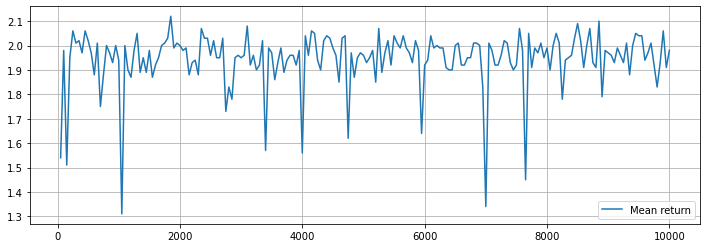

Episode: 10000, Return: 2.0, AvgReturn[50]: 2


In [10]:
seed = 1337
x, y = env.observation_space.shape
agent = DynaQAgent(
    x * y, env.action_space.n , lr=0.1, gamma=0.95, eps=0.1, seed=seed,
    f_model=Model
)

log_q = train(env, agent, n_episodes=10_001, on_model_updates=5, seed=seed, show_progress_schedule=50)

In [11]:
def dyna_q_agent(observation, configuration):
    if np.sum(observation['board']) == 0: 
        return np.random.randint(7)
    obs = np.array(observation['board']).reshape(6,7)
    action, _states = agent.act(obs)
    return int(action)

In [12]:
kaggle_env = env.get_kaggle_env()
kaggle_env.reset()
kaggle_env.run([dyna_q_agent, "negamax"])
kaggle_env.render(mode="ipython", width=500, height=450)

NameError: name 'gym_env' is not defined

# Вывод по Dyna-Q

 - алгоритм не учится быстро, вероятно нужно учитывать входные параметры как матрицу
 - надо попробовать с большим timestamps и шагов в dream
 
## Дополнительно:
 - созданием агента который сам играет на лидерборде не занимался, не успел разобраться как выгрузить веса из SB3 в submission.py
 - Идеи для улучшения - попробовать 
   - CnnPolicy для DQN, 
   - DQN-Dueling из HW1,
   - MCST

In [ ]:
# Часть посвященная сбору и отсылке агента - не прорабатывал

PyTorch conversion adapted from https://github.com/hill-a/stable-baselines/issues/372

In [40]:
for key, value in model.get_parameters()['policy'].items():
    print(key, value.shape)

mlp_extractor.policy_net.0.weight torch.Size([64, 42])
mlp_extractor.policy_net.0.bias torch.Size([64])
mlp_extractor.policy_net.2.weight torch.Size([64, 64])
mlp_extractor.policy_net.2.bias torch.Size([64])
mlp_extractor.value_net.0.weight torch.Size([64, 42])
mlp_extractor.value_net.0.bias torch.Size([64])
mlp_extractor.value_net.2.weight torch.Size([64, 64])
mlp_extractor.value_net.2.bias torch.Size([64])
action_net.weight torch.Size([7, 64])
action_net.bias torch.Size([7])
value_net.weight torch.Size([1, 64])
value_net.bias torch.Size([1])


In [41]:
import torch as th
import torch.nn as nn

class PyTorchMlpPolicy(nn.Module):
    def __init__(self):
        super(PyTorchMlpPolicy, self).__init__()
        self.pi_fc0 = nn.Linear(42, 64)
        self.pi_fc1 = nn.Linear(64, 64)
        self.pi = nn.Linear(64, 7)

        self.tanh = th.tanh
        self.out_activ = nn.Softmax(dim=0)

    def forward(self, x):
        x = self.tanh(self.pi_fc0(x))
        x = self.tanh(self.pi_fc1(x))
        x = self.pi(x)
        x = self.out_activ(x)
        return x

In [42]:
def copy_mlp_weights(baselines_model):
    torch_mlp = PyTorchMlpPolicy()
    model_params = baselines_model.get_parameters()['policy']
    # Get only the policy parameters
    policy_keys = [key for key in model_params.keys() if "pi" in key] # or "c" in key]
    policy_params = [model_params[key] for key in policy_keys]

    for (th_key, pytorch_param), key, policy_param in zip(torch_mlp.named_parameters(), policy_keys, policy_params):
        param = policy_param.copy()
        # Copy parameters from stable baselines model to pytorch model

        # weight of fully connected layer
        if len(param.shape) == 2:
            param = param.T

        # bias
        if 'b' in key:
            param = param.squeeze()

        param = th.from_numpy(param)
        pytorch_param.data.copy_(param.data.clone())

    return torch_mlp


In [43]:
th_model = copy_mlp_weights(model)

In [52]:
import torch
from torch.autograd import Variable

episode_reward = 0
done = False
obs = env.reset()
step_cnt = 0
max_moves = gym_env.get_kaggle_env().configuration.columns * gym_env.get_kaggle_env().configuration.rows

while (not done) and step_cnt <= max_moves:
    step_cnt += 1
    th_obs = Variable(torch.from_numpy(obs.flatten()))
    action = th.argmax(th_model(th_obs)).item()
    
    print('action:', action)
    if obs[0][0][action] != 0:
        print('skipping illegal move')
    else:
        obs, reward, done, info = env.step([action])
        gym_env.render()
        episode_reward += reward
    print()


NameError: name 'th' is not defined

PyTorch serialization adapted from https://www.kaggle.com/c/connectx/discussion/126678

In [45]:
torch.save(th_model.state_dict(), 'thmodel')

In [46]:
import base64
with open('thmodel', 'rb') as f:
    raw_bytes = f.read()
    encoded_weights = base64.encodebytes(raw_bytes)

In [47]:
print(encoded_weights)

b'UEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAQABIAdGhtb2RlbC9kYXRhLnBrbEZCDgBaWlpaWlpa\nWlpaWlpaWoACY2NvbGxlY3Rpb25zCk9yZGVyZWREaWN0CnEAKVJxAShYDQAAAHBpX2ZjMC53ZWln\naHRxAmN0b3JjaC5fdXRpbHMKX3JlYnVpbGRfdGVuc29yX3YyCnEDKChYBwAAAHN0b3JhZ2VxBGN0\nb3JjaApGbG9hdFN0b3JhZ2UKcQVYAQAAADBxBlgDAAAAY3B1cQdNgAp0cQhRSwBLQEsqhnEJSypL\nAYZxColoAClScQt0cQxScQ1YCwAAAHBpX2ZjMC5iaWFzcQ5oAygoaARoBVgBAAAAMXEPaAdLQHRx\nEFFLAEtAhXERSwGFcRKJaAApUnETdHEUUnEVWA0AAABwaV9mYzEud2VpZ2h0cRZoAygoaARoBVgB\nAAAAMnEXaAdNABB0cRhRSwBLQEtAhnEZS0BLAYZxGoloAClScRt0cRxScR1YCwAAAHBpX2ZjMS5i\naWFzcR5oAygoaARoBVgBAAAAM3EfaAdLQHRxIFFLAEtAhXEhSwGFcSKJaAApUnEjdHEkUnElWAkA\nAABwaS53ZWlnaHRxJmgDKChoBGgFWAEAAAA0cSdoB03AAXRxKFFLAEsHS0CGcSlLQEsBhnEqiWgA\nKVJxK3RxLFJxLVgHAAAAcGkuYmlhc3EuaAMoKGgEaAVYAQAAADVxL2gHSwd0cTBRSwBLB4VxMUsB\nhXEyiWgAKVJxM3RxNFJxNXV9cTZYCQAAAF9tZXRhZGF0YXE3aAApUnE4KFgAAAAAcTl9cTpYBwAA\nAHZlcnNpb25xO0sBc1gGAAAAcGlfZmMwcTx9cT1oO0sBc1gGAAAAcGlfZmMxcT59cT9oO0sBc1gC\nAAAAcGlxQH1xQWg7SwFzWAkAAABvdXRfYWN0aXZxQn1xQ2g7SwFzdXNiLlBLBw

In [48]:
import io
import base64
import torch
from torch.autograd import Variable
import random

agent_th_model = PyTorchMlpPolicy()
# encoded_weights =b'gAKKCmz8n ..... [long string]
decoded = base64.b64decode(encoded_weights)
buffer = io.BytesIO(decoded)
agent_th_model.load_state_dict(torch.load(buffer))

<All keys matched successfully>

In [49]:
def my_agent(observation, configuration):
    obs = np.array(observation['board'])
    th_obs = Variable(torch.from_numpy(obs)).float()
    y = agent_th_model(th_obs)
    action = th.argmax(agent_th_model(th_obs)).item()
    if observation.board[action] == 0:
        return action
    else:
        return random.choice([c for c in range(configuration.columns) if observation.board[c] == 0])


In [50]:
kaggle_env = gym_env.get_kaggle_env()
kaggle_env.reset()
kaggle_env.run([my_agent, "negamax"])
kaggle_env.render(mode="ipython", width=500, height=450)

In [ ]:
from kaggle_environments import evaluate

def mean_reward(rewards):
    return sum(r[0] for r in rewards) / sum(r[0] + r[1] for r in rewards)

# Run multiple episodes to estimate its performance.
print("My Agent vs Random Agent:", mean_reward(evaluate("connectx", [my_agent, "random"], num_episodes=10)))
print("My Agent vs Negamax Agent:", mean_reward(evaluate("connectx", [my_agent, "negamax"], num_episodes=10)))

My Agent vs Random Agent: 0.6
My Agent vs Negamax Agent: 0.0


In [ ]:
import inspect
import os

def write_agent_to_file(file):
#     with open(file, "a" if os.path.exists(file) else "w") as f:
    with open(file, "w") as f:
        f.write('import numpy as np\n')
        f.write('import random\n')
        f.write('import torch as th\n')
        f.write('import torch.nn as nn\n')
        f.write('import io\n')
        f.write('import base64\n')
        f.write('import torch\n')
        f.write('from torch.autograd import Variable\n')

        f.write('class PyTorchMlpPolicy(nn.Module):\n')
        f.write('    def __init__(self):\n')
        f.write('        super(PyTorchMlpPolicy, self).__init__()\n')
        f.write('        self.pi_fc0 = nn.Linear(42, 64)\n')
        f.write('        self.pi_fc1 = nn.Linear(64, 64)\n')
        f.write('        self.pi = nn.Linear(64, 7)\n')
        f.write('        self.tanh = th.tanh\n')
        f.write('        self.out_activ = nn.Softmax(dim=0)\n')
        f.write('    def forward(self, x):\n')
        f.write('        x = self.tanh(self.pi_fc0(x))\n')
        f.write('        x = self.tanh(self.pi_fc1(x))\n')
        f.write('        x = self.pi(x)\n')
        f.write('        x = self.out_activ(x)\n')
        f.write('        return x\n')

        f.write('agent_th_model = PyTorchMlpPolicy()\n')
        f.write('encoded_weights =' + str(encoded_weights) + '\n')
        f.write('decoded = base64.b64decode(encoded_weights)\n')
        f.write('buffer = io.BytesIO(decoded)\n')
        f.write('agent_th_model.load_state_dict(torch.load(buffer))\n')

        f.write(inspect.getsource(my_agent))

write_agent_to_file(log_dir + "submission.py")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [36]:
# Note: Stdout replacement is a temporary workaround.
import sys
out = sys.stdout
from kaggle_environments import utils
submission = utils.read_file(log_dir + "submission.py")
submission_agent = utils.get_last_callable(submission)
sys.stdout = out

kaggle_env.run([submission_agent, submission_agent])
print("Success!" if kaggle_env.state[0].status == kaggle_env.state[1].status == "DONE" else "Failed...")

kaggle_env.play([submission_agent, None])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Success!


https://www.kaggle.com/c/connectx/leaderboard